### Use standalone verison of ICEPLUME to calculate subglacial discharge from rom

In [28]:
%matplotlib inline

# import modules
from datetime import datetime, timedelta
import subprocess
import pickle

import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

import pyroms
from cmocean import cm

plt.rcParams['figure.figsize'] = [18, 16]
plt.rcParams['font.size'] = 20

In [13]:
# -------------- functionals --------------------------------
def get_zr(zeta, h, vgrid):
    """ get z at rho points from grid and zeta info. """

    ti = zeta.shape[0]
    zr = np.empty((ti, vgrid.N) + h.shape, 'd')
    if vgrid.Vtrans == 1:
        for n in range(ti):
            for k in range(vgrid.N):
                z0 = vgrid.hc * vgrid.s_rho[k] + (h - vgrid.hc) * vgrid.Cs_r[k]
                zr[n, k, :] = z0 + zeta[n, :] * (1.0 + z0 / h)
    elif vgrid.Vtrans == 2 or vgrid.Vtrans == 4 or vgrid.Vtrans == 5:
        for n in range(ti):
            for k in range(vgrid.N):
                z0 = (vgrid.hc * vgrid.s_rho[k] + h * vgrid.Cs_r[k]) / (vgrid.hc + h)
                zr[n, k, :] = zeta[n, :] + (zeta[n, :] + h) * z0

    return zr


def get_zw(zeta, h, vgrid):
    """ get z at rho points from grid and zeta info. """

    ti = zeta.shape[0]
    zw = np.empty((ti, vgrid.Np) + h.shape, 'd')
    if vgrid.Vtrans == 1:
        for n in range(ti):
            for k in range(vgrid.Np):
                z0 = vgrid.hc * vgrid.s_w[k] + (h - vgrid.hc) * vgrid.Cs_w[k]
                zw[n, k, :] = z0 + zeta[n, :] * (1.0 + z0 / h)
    elif vgrid.Vtrans == 2 or vgrid.Vtrans == 4 or vgrid.Vtrans == 5:
        for n in range(ti):
            for k in range(vgrid.Np):
                z0 = (vgrid.hc * vgrid.s_w[k] + h * vgrid.Cs_w[k]) / (vgrid.hc + h)
                zw[n, k, :] = zeta[n, :] + (zeta[n, :] + h) * z0

    return zw

In [14]:
# ------------ build the executable ------------------------------------
subprocess.call('cd ..; ./build.bash', shell=True)

0

In [26]:
# ------------ parameters -----------------------------------------------
W = 2000.
Ds = 100.
m2amp = 0.00
s2amp = 0.00
dth = 50.
dthp = 0.025
runoff = 250.
runoff_sratio = 0

if runoff_sratio == 0:
    apd = '_w%05d_s%03d_r%04d_m2amp%4.2f_s2amp%4.2f_dth%03d_dthp%5.3f' \
          % (W, Ds, runoff, m2amp, s2amp, dth, dthp)
else:
    apd = '_w%05d_s%03d_r%04d_rr%4.2f_m2amp%4.2f_s2amp%4.2f_dth%03d_dthp%5.3f' \
          % (W, Ds, runoff, runoff_sratio, m2amp, s2amp, dth, dthp)

dx0 = 200
dy0 = 200

grid_file = '/glade/u/home/chuning/tidal_fjord/tidal_fjord_grid' + apd + '.nc'
hist_file = '/glade/scratch/chuning/tmpdir_tidal_fjord/outputs' + \
        apd + '/outputs/1900/tidal_fjord' + apd + '_his_1900-01-21T01:00:00.nc'
fname_pkl = '/glade/work/chuning/tidal_fjord/data/tidal_fjord_vol' + apd + '.pickle'

In [16]:
# load grid
grd = pyroms.grid.get_ROMS_grid(None, hist_file=hist_file, grid_file=grid_file)
N = grd.vgrid.N
h = grd.vgrid.h[136:137, 2:3]

Load cartesian grid from file


In [32]:
# load volume data from pickle
fh = open(fname_pkl, 'rb')
data_vol = pickle.load(fh)
fh.close()
# time = data['time']
salt_vol = data_vol['salt']
vol = data_vol['vol']

In [17]:
fin = nc.Dataset(fname, 'r')
time = fin.variables['ocean_time'][:]
zeta = fin.variables['zeta'][:]
salt = fin.variables['salt'][:]
temp = fin.variables['temp'][:]
dye01 = fin.variables['dye_01'][:]
v = 0.5*(fin.variables['v'][:, :, 1:] +
         fin.variables['v'][:, :, :-1])
w = 0.5*(fin.variables['w'][:, 1:] +
         fin.variables['w'][:, :-1])
fin.close()

tN = len(time)

zw = get_zw(zeta, h, grd.vgrid)
zr = get_zr(zeta, h, grd.vgrid)

In [18]:
# ------------ initiate variables --------------------------------------
f = open('../outputs/plume_out_zr.txt', 'rb')
header_zr = f.readline().split()
f.close()
f = open('../outputs/plume_out_zw.txt', 'rb')
header_zw = f.readline().split()
f.close()

for i in range(len(header_zr)):
    header_zr[i] = header_zr[i].decode('utf-8')
for i in range(len(header_zw)):
    header_zw[i] = header_zw[i].decode('utf-8')

data = {}
for (i, header) in enumerate(header_zr):
    data[header] = np.zeros((tN, N))
for (i, header) in enumerate(header_zw):
    data[header] = np.zeros((tN, N+1))

print('Run the module')

for ti in range(tN):
    np.savetxt('../data/iceplume_zw.txt', zw[ti, :, 0, 0])
    np.savetxt('../data/iceplume_t.txt', temp[ti, :, 0, 0])
    np.savetxt('../data/iceplume_s.txt', salt[ti, :, 0, 0])
    np.savetxt('../data/iceplume_dye01.txt', dye01[ti, :, 0, 0])
    np.savetxt('../data/iceplume_v.txt', v[ti, :, 0, 0])
    np.savetxt('../data/iceplume_w.txt', w[ti, :, 0, 0])

    # ------------ run the executable --------------------------------------
    subprocess.call('cd ..; ./iceplume_test.exe', shell=True)

    # ------------ load results from txt files -----------------------------
    data_zr = np.loadtxt('../outputs/plume_out_zr.txt', skiprows=1)
    data_zw = np.loadtxt('../outputs/plume_out_zw.txt', skiprows=1)

    for (i, header) in enumerate(header_zr):
        if str(header) != 'lev':
            data[header][ti, :] = data_zr[:, i]
    for (i, header) in enumerate(header_zw):
        data[header][ti, :] = data_zw[:, i]


Run the module


In [19]:
time2d = np.tile((time-time[0])/(24*60*60), (N, 1)).T
time2dw = np.tile((time-time[0])/(24*60*60), (N+1, 1)).T
det = data['det']
ent = data['ent']
sp = data['s']
tp = data['t']
det[det==0] = np.nan
ent[ent==0] = np.nan
sp[sp==0] = np.nan
tp[tp==0] = np.nan
det = np.ma.masked_where(np.isnan(det), det)
ent = np.ma.masked_where(np.isnan(ent), ent)
sp = np.ma.masked_where(np.isnan(sp), sp)
tp = np.ma.masked_where(np.isnan(tp), tp)

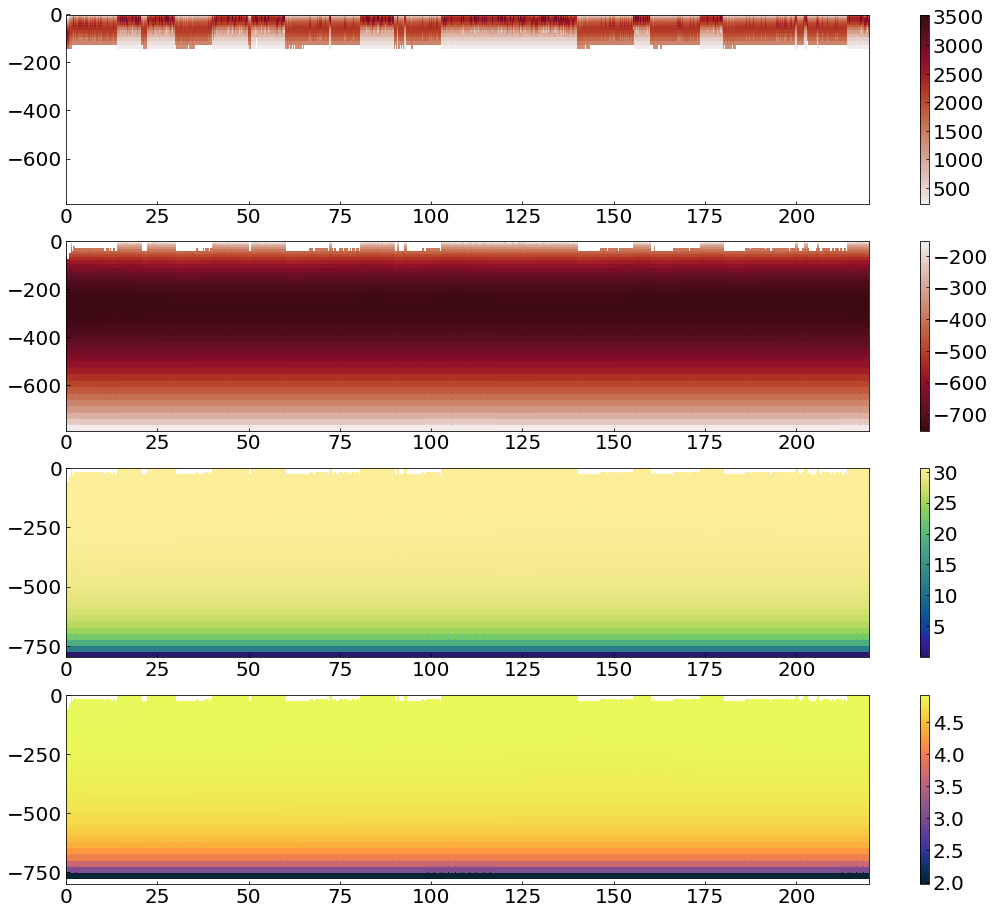

In [20]:
fig, axs = plt.subplots(4, 1)
pc0 = axs[0].pcolor(time2d, zr.squeeze(), det, cmap=cm.amp)
pc1 = axs[1].pcolor(time2d, zr.squeeze(), ent, cmap=cm.amp_r)
fig.colorbar(pc0, ax=axs[0])
fig.colorbar(pc1, ax=axs[1])

pc2 = axs[2].pcolor(time2dw, zw.squeeze(), sp, cmap=cm.haline)
pc3 = axs[3].pcolor(time2dw, zw.squeeze(), tp, cmap=cm.thermal)
fig.colorbar(pc2, ax=axs[2])
fig.colorbar(pc3, ax=axs[3])